In [1]:
%matplotlib notebook
import sys
import amfe
import matplotlib.pyplot as plt
import numpy as np
import copy
import pandas as pd
from pyfeti import feti_solver as fetisolver
from pyfeti import cyclic
sys.path.append('..')

from python.cases import case_dict, case_generator


Python was not able to load the fast fortran assembly routines.

Python was not able to load the fast fortran material routines.



In [2]:
caseid = 4
nsectors = case_dict[caseid]['nsectors']
dim = case_dict[caseid]['dimension']
cyc_pert, m, my_comp, s = case_generator(case_dict[caseid])



*************************************************************

Loading Abaqus-mesh from ..\mesh\simple_3d_turbine_14.inp
Can not read the given string list
WARNING! 3D case were selected
Mesh ..\mesh\simple_3d_turbine_14.inp successfully imported. 
Assign a material to a physical group.
*************************************************************
Preallocating the stiffness matrix
Done preallocating stiffness matrix with 160 elements and 963 dofs.
Time taken for preallocation: 0.01 seconds.


<IPython.core.display.Javascript object>


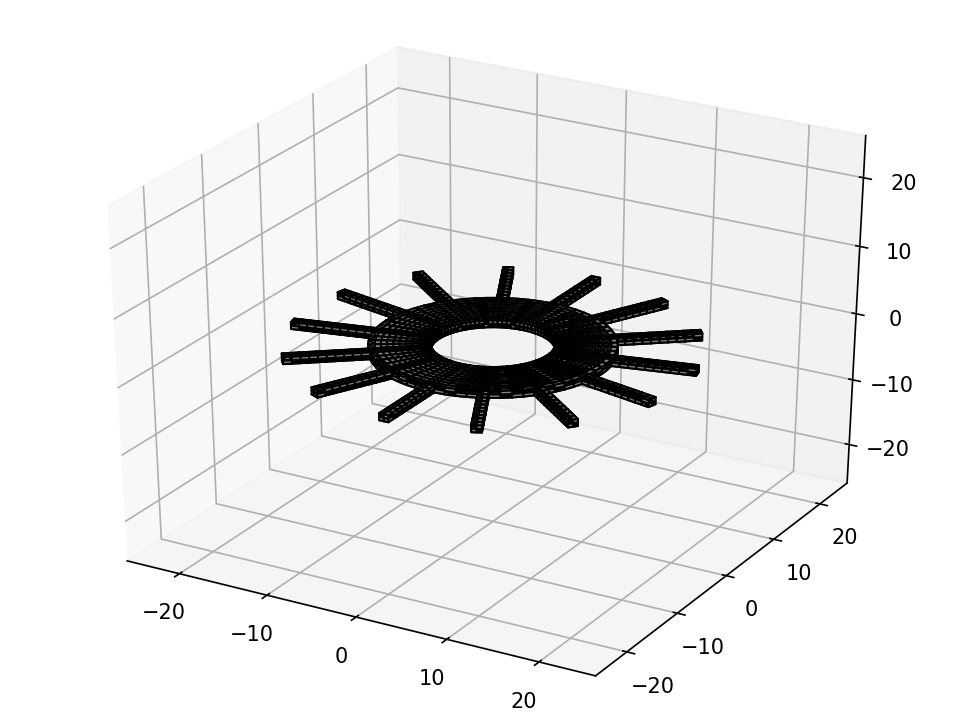

In [3]:
bc = case_dict[caseid]['bc']
ax = amfe.plot_cyclic_mesh(m,nsectors,bc=bc)

In [ ]:
%%time
sigma=0.0
mu=0.0
K_dict,M_dict, B_dict, f_dict = cyc_pert.create_cyclic_perturbed_system(20,sigma=sigma,mu=mu)
freq, modes_dict, info_dict = fetisolver.cyclic_eig(K_dict,M_dict,B_dict,f_dict,num_of_modes=10,use_precond=True)
new_modes_dict = cyclic.maptoglobal(modes_dict,s)

In [ ]:
amfe.plot_deform_cyclic_mesh(m,nsectors,new_modes_dict,u_id=0,factor=100,color='grey',alpha=1.0,bc=bc,plot_nodes=False,linewidth=0.1)

In [ ]:
freq

In [ ]:
import mpl_toolkits.mplot3d as a3
from ipywidgets import interact
@interact(scalling=(0,10,1),factor=(-10,10,0.1),mode_id=(0,30,1)) 
def plot(scalling=1,factor=10.0,mode_id=0):
    if dim == 2:
        fig3, ax3 = plt.subplots(figsize=(5,5))
    elif dim==3:
        fig3 = plt.figure()
        ax3 = a3.Axes3D(fig3) 
    
    ax3 = amfe.plot_deform_cyclic_mesh(m, nsectors, new_modes_dict, mode_id, ax=ax3, bc=bc,factor=10**(scalling)*factor, color_id= 0,
                                       linewidth=0.1,plot_nodes=False,alpha=1.0)
    return ax3
    

In [ ]:
plt.figure()
plt.bar(list(range(len(freq))),freq[:nsectors])

In [ ]:
fig4 = plt.figure(figsize=(10,10))
N = 3
factor = 1.0
shift = 0
def plot1(factor):
    
    for i in range(N):
        for j in range(N):
            mode_id = N*i + j + shift
            u = new_modes_dict[i].T.real[mode_id,:]
            if dim == 2:
                ax = fig4.add_subplot(3, 3, N*i + j + 1)
            else:
                ax = fig4.add_subplot(3, 3, N*i + j + 1, projection='3d')
            ax.set_title('$f$ = %0.2f [Hz]' %freq[mode_id])
            amfe.plot_deform_cyclic_mesh(m,  nsectors, new_modes_dict, mode_id, bc=0.5*bc, factor=100*factor, ax=ax, 
                                         linewidth=0.1, alpha=1.0,plot_nodes=False,color_id= 0)
            ax.set_xlabel('x [m]')
            ax.set_ylabel('y [m]')
            ax.set_zlabel('z [m]')
            
plot1(1.0)

In [ ]:
from matplotlib.animation import FuncAnimation, writers
import matplotlib.animation as animation

u_list = 0.75*np.sin(np.linspace(0, 2.0*np.pi , 40 ))
ani = FuncAnimation(fig4, plot1, frames= u_list, blit=True, interval=1)   



Writer = animation.writers['imagemagick']
writer = Writer(fps=20, metadata=dict(artist='Guilherme Jenovencio'), bitrate=300)
ani.save('3D_simple_no_minstuning_blade_disk_v1.gif', dpi=200, writer=writer)

In [4]:
#creating pandas pandasframe
columns = []
num_of_modes=10
prefix = 'w'
for i in range(num_of_modes):
    columns.append(prefix + str(i))
    
df = pd.DataFrame(data=None, columns=columns)


In [5]:
import time

sigma= 1.0E3
n_samples = 2
mu = 0.0
mode_sample_dict = {}
for i in range(n_samples):
    start = time.time()
    cyc_pert.perturbation_order=5
    K_dict,M_dict, B_dict, f_dict = cyc_pert.create_cyclic_perturbed_system(i,sigma=sigma,mu=mu)
    freq, modes_dict, info_dict = fetisolver.cyclic_eig(K_dict,M_dict,B_dict,f_dict,num_of_modes=num_of_modes)
    new_modes_dict = cyclic.maptoglobal(modes_dict,s)
    mode_sample_dict[i] = new_modes_dict
    df.loc[i] = freq
    end = time.time()
    print('Sample %i, simulation time = %f' %(i,end-start))
    

Sample 0, simulation time = 1734.347573
Sample 1, simulation time = 1907.647799


In [6]:
df

,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9
0,10.151085,12.262217,12.656960,12.987536,13.393012,13.929811,13.986580,14.276198,14.563429,14.711494
1,10.151073,12.264656,12.656936,12.974681,13.373721,13.831745,13.929832,14.276137,14.541760,14.642429


<IPython.core.display.Javascript object>


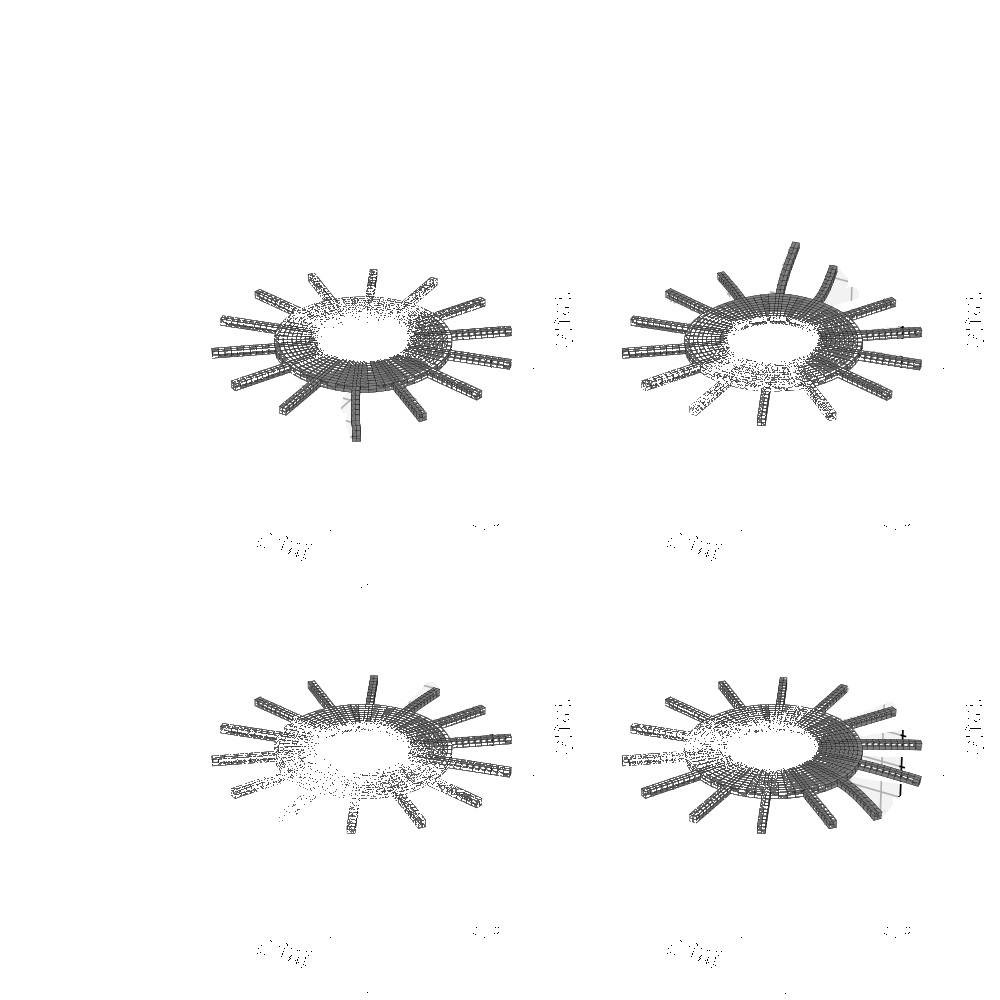

In [7]:
fig5= plt.figure(figsize=(10,10))
#plt.subplots_adjust( wspace=0.5, hspace=0.5)
#plt.axis('off')
N = 3
sample_id = 1
factor = 50
shift = 0
def plot2(factor):
    for i in range(N):
        for j in range(N):
            mode_id = N*i + j + shift
            u = new_modes_dict[i].T.real[mode_id,:]
            if dim == 2:
                ax = fig5.add_subplot(3, 3, N*i + j + 1)
            else:
                ax = fig5.add_subplot(3, 3, N*i + j + 1, projection='3d')
            ax.set_title('$f$ = %0.2f [Hz]' %freq[mode_id])
            amfe.plot_deform_cyclic_mesh(m,  nsectors, mode_sample_dict[sample_id], mode_id, bc=0.5*bc, factor=100*factor, ax=ax, 
                                         linewidth=0.1, alpha=1.0,plot_nodes=False,color_id= 0)
            ax.set_xlabel('x [m]')
            ax.set_ylabel('y [m]')
            ax.set_zlabel('z [m]')

        

In [9]:
from matplotlib.animation import FuncAnimation, writers
import matplotlib.animation as animation

u_list = 0.4*np.sin(np.linspace(0, 2.0*np.pi , 60 ))
ani = FuncAnimation(fig5, plot2, frames= u_list, blit=True, interval=1)   



Writer = animation.writers['imagemagick']
writer = Writer(fps=30, metadata=dict(artist='Guilherme Jenovencio'), bitrate=300)
ani.save('3D_simple_mistuning_blade_disk_6.gif', dpi=300, writer=writer)